<a href="https://colab.research.google.com/github/schoolkidrich/CUNY_MSDS/blob/main/DATA_622/final/data622_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data 622 - Final Project**
**Authors:** Devin Teran, Dennis Pong, Richard Zheng, Katie Evers

**Date:** 12/10/2021

# **Introduction**

**Background**  
For our final project we analyzed a dataset that contains information about mall customers, which includes age, gender, annual income, and spending score.  This dataset was obtained from [Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python).  

**Problem Statement**  
In our analysis we will use machine learning techniques to develop customer segmentation and predict spending score.

# **Importing Libraries and Data**


In [ ]:
# !pip install pycaret
# !pip install pycaret-nightly
# !pip install scikit-learn==0.24

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from matplotlib.legend_handler import HandlerLine2D

In [ ]:
link = 'https://raw.githubusercontent.com/schoolkidrich/CUNY_MSDS/main/DATA_622/final/Mall_Customers.csv'
df = pd.read_csv(link, index_col = 'CustomerID')

# **Data Overview**

---


**Gender** (categorical) - gender of the customer

**Age** (integer) - age of the customer

**Annual Income (k$)** (integer) - how much does the customer make annually in thousands

**Spending Score** (integer) - this is a score (0-100) for how much a customer will spend based on their purchase history and customer data.  In several of our models, this will be our target variable that we will be predicting.

---



This dataset contains 200 rows and 4 columns (3 numerical and 1 categorical). It is very clean with no missing values.

In [ ]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [ ]:
df.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

# **Exploratory Data Analysis**

First let's get an idea of the distribution of our numerical variables.
*   The mean **age** is 38.85
*   The mean **annual income** is $60,560
*   The mean **spending score** is 50.20
*   The minimum and maximum values of all three of these variables indicate that the data is widespread and has greater variability



In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


Looking at the below boxplots, we can see that there is one outlier in **annual income** of $137,000

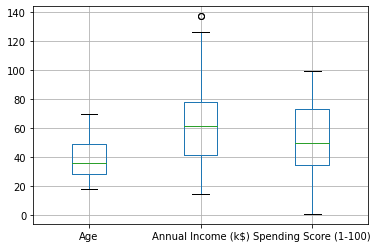

In [ ]:
df.boxplot(column=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])

Next let's look at how the categorical variable is distributed. From the plot we see that gender is pretty balanced with 56% females and 44% males.

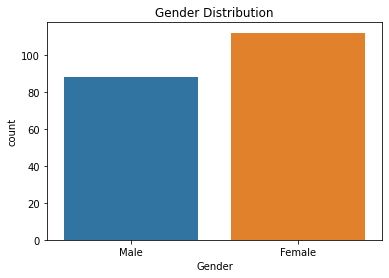

In [ ]:
plt.title('Gender Distribution')
sns.countplot(x=df['Gender'])

In [ ]:
value_cnt = df['Gender'].value_counts()
print("There are",value_cnt[0], "males and",value_cnt[1], "females")

There are 112 males and 88 females


Now we want to view the relationships of the different variables while keeping in mind how **Gender** might affect these relationships.   

From the plots below it is evident that there are more females than males aged around the mean of 39, annual income is distributed fairly similarly, and females tend to have a higher spending score than males.   

From the age and spending score scatter plot, it is evident that for both genders age and spending score have a negative correlation. There doesn't seem to be a correlation in the age and annual income scatter plot.  

In the spending score and annual income scatter plot there seem to be five clusters:  
  1. Low spending score, low annual income
  2. Low spending score, high annual income
  3. Medium spending score, medium annual income
  4. High spending score, low annual income
  5. High spending score, high annual income

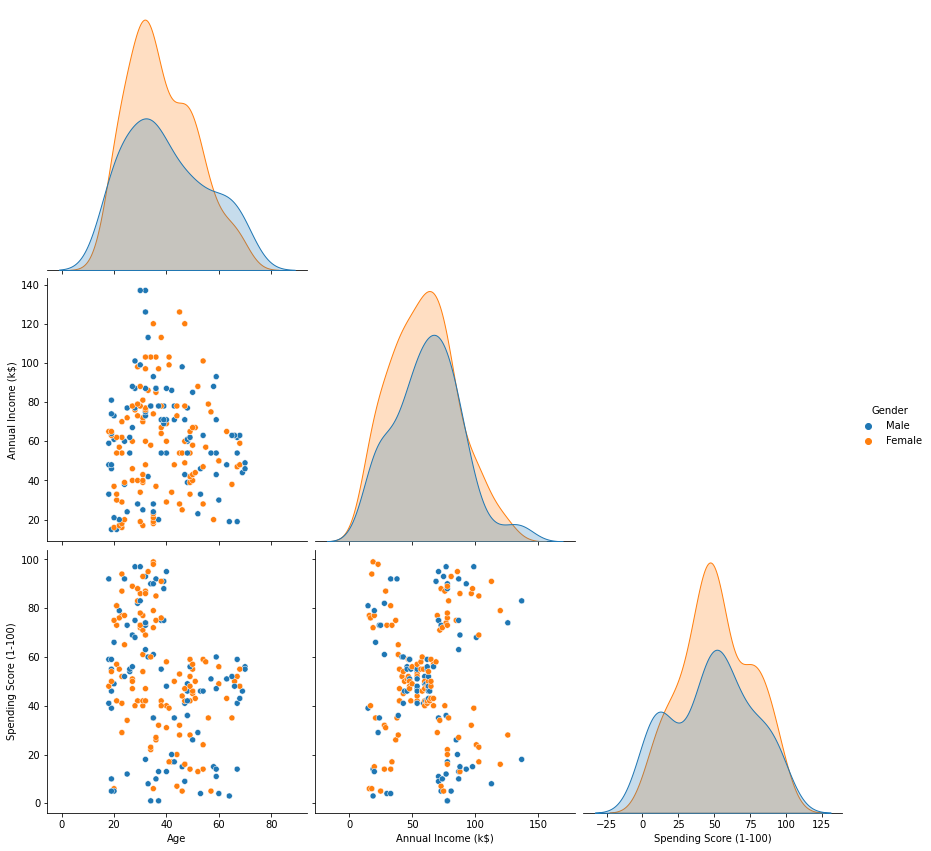

In [ ]:
sns.pairplot(df.loc[:, df.columns != 'CustomerID'],hue="Gender", corner=True, height=4)

Now let's determine if there is any correlation between any of the variables by gender. Comparing the plots below, we see that females and males have opposite correlations for the following:
  1. Age and annual income
  2. Annual income and spending score

In addition, the correlation between age and spending score is larger for females than males.

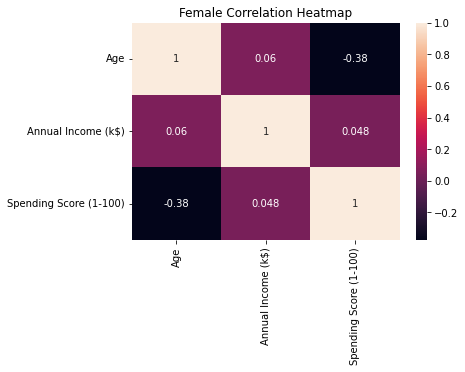

In [ ]:
males= df[df['Gender'] == 'Male']
females = df[df['Gender'] == 'Female']

plt.title('Female Correlation Heatmap')
sns.heatmap(females.corr(), annot=True)

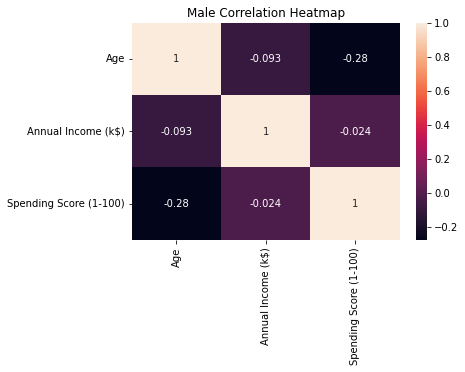

In [ ]:
plt.title('Male Correlation Heatmap')
sns.heatmap(males.corr(), annot=True)

#1 Clustering Techniques
Here we will start by using kmeans clustering to see if find meaningful groups within the customers based on their characteristics. This is called customer segmentation.  Marketers do this in order to better advertise to their customers in an effort to increase customer conversion. We'll start by looking for clusters using age and annual income.  

Here we are running kmeans clustering 10 times starting with 1 clustering and increasing until we have 10 clusters.  With each run we are noting the ineritia value.  In Kmeans clustering, the best number of clusters has the lowest inertia value and lowest number of clusters. 

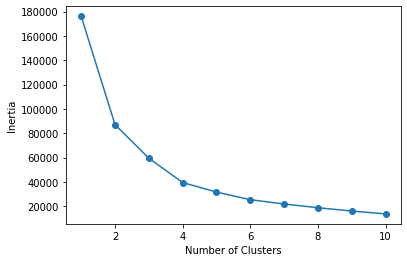

In [ ]:
ss=[]
for i in range(1,11):
  kmeans = KMeans(i)
  kmeans.fit(df[['Age','Annual Income (k$)']])
  ss.append(kmeans.inertia_)

plt.plot(range(1,11),ss,marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()



We will choose 4 as our number of clusters to create.  Even though the inertia continues to decrease, it isn't significant and the number of clusters continues to increase, which we don't want.

Now we will plot what 4 clusters looks like with our data.

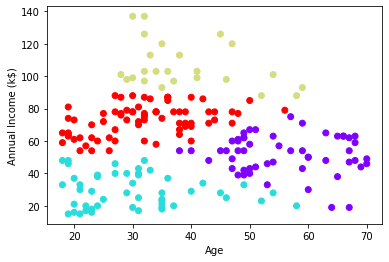

In [ ]:
kmeans = KMeans(4)
kmeans.fit(df[['Age','Annual Income (k$)']])
  
df['Predicted_Cluster'] = kmeans.fit_predict(df[['Age','Annual Income (k$)']])
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.scatter(df['Age'],df['Annual Income (k$)'],c=df['Predicted_Cluster'],cmap='rainbow')

#####**Cluster Findings**


*   If salary is under $60,000, then there appears to be a slight trend that the older you are the more money you make
*   When annual salary >\$60,000, it appears age factors less into income with the exception of customers over the age of 60.  Customers over 60 do not appear to be hire earners, which would makes sense if they are retired.
* Collecting additional data like occupation and average purchase amount would be helpful for the mall and could help improve the clustering results




## Adding in Gender
Our data has 2 values for Gender: **Female** and **Male**.  

In [ ]:
df['Gender'].unique()

array(['Male', 'Female'], dtype=object)

Since Kmeans clustering can't traditionally handle categorical data we are going to create 2 separate clusters - one for female and one for male and visually compare them.   

Let's start by finding the optimal number of clustering for data where **Gender = Female**.

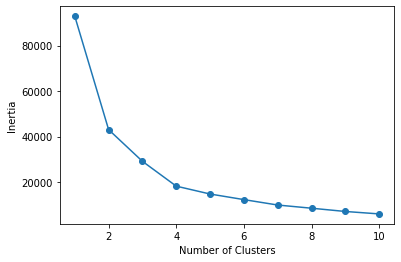

In [ ]:
female = df[df['Gender'] == 'Female']
ss=[]
for i in range(1,11):
  kmeans = KMeans(i)
  kmeans.fit(female[['Age','Annual Income (k$)']])
  ss.append(kmeans.inertia_)

plt.plot(range(1,11),ss,marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()



Let's choose our number of clusters at 4.  The inertia is pretty low and the number of clusters is low.

We're going to skip to find the optimal number of clusters for our data where **Gender = Male**.

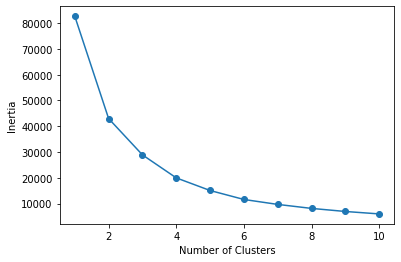

In [ ]:
male = df[df['Gender'] == 'Male']
ss=[]
for i in range(1,11):
  kmeans = KMeans(i)
  kmeans.fit(male[['Age','Annual Income (k$)']])
  ss.append(kmeans.inertia_)

plt.plot(range(1,11),ss,marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Again, we will choose the optimal number of clusters to be 4 for our **male** data.

Now let's view both clusters for **male** and **female** side by side. 

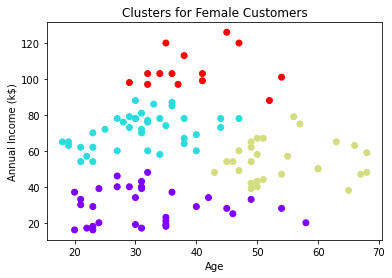

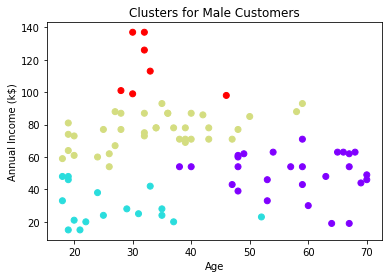

In [ ]:
import warnings
warnings.filterwarnings('ignore')

kmeans_female = KMeans(4)
kmeans_female.fit(female[['Age','Annual Income (k$)']])
female['Predicted_Cluster'] = kmeans_female.fit_predict(female[['Age','Annual Income (k$)']])

kmeans_male = KMeans(4)
kmeans_male.fit(male[['Age','Annual Income (k$)']])
male['Predicted_Cluster'] = kmeans_male.fit_predict(male[['Age','Annual Income (k$)']])

f, axes = plt.subplots(1, 1)

plt.scatter(female['Age'],female['Annual Income (k$)'],c=female['Predicted_Cluster'],cmap='rainbow')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.title('Clusters for Female Customers')

f, axes = plt.subplots(1, 1)
plt.scatter(male['Age'],male['Annual Income (k$)'],c=male['Predicted_Cluster'],cmap='rainbow')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.title('Clusters for Male Customers')

plt.show()

#####**Cluster Findings**


*   There is a cluster of high paying women (>\$100k) that is larger than the similar salary group for men.  When targeting high paying customers, the mall owner will know that it's more likely women, but the top 2 highest salary customers are male.
*   For salary under $60k, the gap between age is stronger for males than female
* Both female and male has the same number of clusters being optimized at 4




# 2 Logistic Regression

In [ ]:
# encodes all categorical fields to dummy variables and normalizes numerical columns
def pipeline_model(model):
  preprocess = ColumnTransformer(
  transformers = [
    ('cat', OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include = 'object')),
    ('num', StandardScaler(), make_column_selector(dtype_exclude = 'object'))
    ]
  )

  pipeline = Pipeline(
    steps = [
      ('preprocess', preprocess),
      ('model', model)
    ]
  )
  return pipeline

# changes numerical values to binary based on set threshold
def num_to_binary(list, thresh):
  result = []
  for item in list:
    if item >= thresh:
      result.append(1)
    else:
      result.append(0)
  return result

Since most of the data we have is numerical, we decided to try to fit a linear model through the data.

In [ ]:
lm_X = df[['Gender','Age','Annual Income (k$)']]
lm_y = df['Spending Score (1-100)']
lm_X_train, lm_X_test, lm_y_train, lm_y_test = train_test_split(lm_X, lm_y, test_size = 0.20, random_state = 50)

linear_model = pipeline_model(LinearRegression())

linear_model.fit(lm_X_train, lm_y_train)
linear_model.score(lm_X_test, lm_y_test)

0.09166444709506338

Due to poor performance from the linear model we decided to bucket the spending score, based on the average score, and performed logistic regression

In [ ]:
binary_df = df.copy()
avg_score = binary_df['Spending Score (1-100)'].mean()
binary_df['buy_ind'] = num_to_binary(df['Spending Score (1-100)'], avg_score)

logm_X = binary_df[['Gender','Age','Annual Income (k$)']]
logm_y = binary_df['buy_ind']
logm_X_train, logm_X_test, logm_y_train, logm_y_test = train_test_split(logm_X, logm_y, test_size = 0.20, random_state = 50)

log_model = pipeline_model(LogisticRegression())
log_model.fit(logm_X_train, logm_y_train)
log_model.score(logm_X_test, logm_y_test)

0.6

We see that logistic regression performanced significantly better than our attempt with linear regression (even with the default 0.5 threshold)

In [ ]:
log_predictions = pd.DataFrame(logm_y_test)
log_predictions['prediction'] = log_model.predict(logm_X_test)
log_predictions['probability'] = log_model.predict_proba(logm_X_test)[:,1]
log_predictions.head()

,buy_ind,prediction,probability
CustomerID,,,
113,0,0,0.458947
166,1,0,0.456492
13,0,0,0.301085
74,1,0,0.255250
145,0,1,0.617223


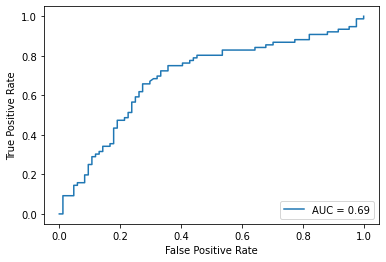

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true = logm_y_train, y_score = log_model.predict_proba(logm_X_train)[:,1])
auc = metrics.auc(fpr, tpr)
roc_curve = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = auc)
roc_curve.plot()
plt.show()

We then plotted an ROC curve to see what the optimal threshold would be. Based on the curve, we see that ~0.4 is the optimal threshold for our training data

In [ ]:
log_predictions['adjusted_pred'] = num_to_binary(log_predictions['probability'], 0.40)
metrics.accuracy_score(log_predictions['buy_ind'], log_predictions['adjusted_pred'])

0.725

Generalizing the optimal threshold to our testing data, we were able to improve the performance of the model again. 

# 3 Decision Tree
Next we will use a decision tree to predict spending score.

In [ ]:
#convert catgorical variable to numerical
df_dt = df.copy()
df_dt['Gender'].replace({'Male':0, 'Female':1}, inplace=True)

In [ ]:
df_dt.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Predicted_Cluster
CustomerID,,,,,
1,0,19,15,39,1
2,0,21,15,81,1
3,1,20,16,6,1
4,1,23,16,77,1
5,1,31,17,40,1


Initially we tried leaving spending score as it is as values 0-100. However, the performance was very bad so we converted it to a binary variable with 0 as 0-50 and 1 as 51-100.

In [ ]:
def conditions(x):
    if x <= 50:
        return 0
    else:
        return 1

func = np.vectorize(conditions)
Score_Group= func(df_dt["Spending Score (1-100)"])

df_dt["spending score binary"] = Score_Group
df_dt.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Predicted_Cluster,spending score binary
CustomerID,,,,,,
1,0,19,15,39,1,0
2,0,21,15,81,1,1
3,1,20,16,6,1,0
4,1,23,16,77,1,1
5,1,31,17,40,1,0


Let's see how the model performs with default parameters.

In [ ]:
X = df_dt.drop(columns=['Spending Score (1-100)', 'spending score binary'], axis=1)
y = df_dt['spending score binary']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=123)

In [ ]:
#start with default parameters
clf_default = DecisionTreeClassifier(random_state=11)
clf_default.fit(X_train,y_train)

# make predictions
y_pred_default = clf_default.predict(X_test)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred_default))

Accuracy: 0.6


In [ ]:
print(confusion_matrix(y_test, y_pred_default))
print(classification_report(y_test, y_pred_default))

[[13  9]
 [ 7 11]]
              precision    recall  f1-score   support

           0       0.65      0.59      0.62        22
           1       0.55      0.61      0.58        18

    accuracy                           0.60        40
   macro avg       0.60      0.60      0.60        40
weighted avg       0.61      0.60      0.60        40



We achieve an accuracy of 60% with default parameters. Next let's try improving our baseline model by finding optimal parameter values.

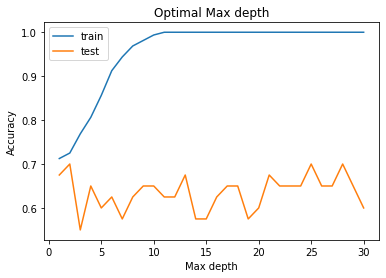

In [ ]:
max_depths = np.linspace(1, 30, 30, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   train_accuracy = metrics.accuracy_score(y_train, train_pred)
   train_results.append(train_accuracy)
   y_pred = dt.predict(X_test)
   test_accuracy = metrics.accuracy_score(y_test, y_pred)
   test_results.append(test_accuracy)

line1 = plt.plot(max_depths, train_results, label="train")
line2 = plt.plot(max_depths, test_results, label = "test")

plt.title("Optimal Max depth")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")

plt.legend()
plt.show()


Based on the plots above, we see that the model overfits for large depth values. The optimal parameter values appear to be max_depth = 9, min_samples_split = 0.3, min_samples_leaf = 0.1. In our final model we achieve an accuracy of 70% with 12 observations predicted incorrectly.

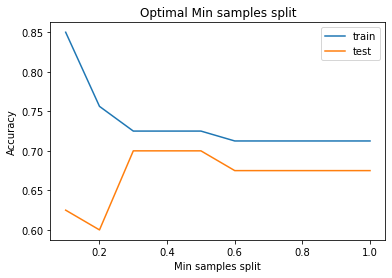

In [ ]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   train_accuracy = metrics.accuracy_score(y_train, train_pred)
   train_results.append(train_accuracy)
   y_pred = dt.predict(X_test)
   test_accuracy = metrics.accuracy_score(y_test, y_pred)
   test_results.append(test_accuracy)

line1 = plt.plot(min_samples_splits, train_results, label="train")
line2 = plt.plot(min_samples_splits, test_results, label = "test")

plt.title("Optimal Min samples split")
plt.xlabel("Min samples split")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

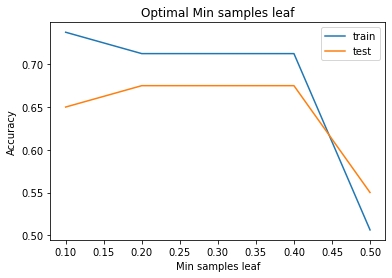

In [ ]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   train_accuracy = metrics.accuracy_score(y_train, train_pred)
   train_results.append(train_accuracy)
   y_pred = dt.predict(X_test)
   test_accuracy = metrics.accuracy_score(y_test, y_pred)
   test_results.append(test_accuracy)

line1 = plt.plot(min_samples_leafs, train_results, label="train")
line2 = plt.plot(min_samples_leafs, test_results, label = "test")

plt.title("Optimal Min samples leaf")
plt.xlabel("Min samples leaf")
plt.ylabel("Accuracy")

plt.legend()
plt.show()


In our final decision tree we will use max_depth = 9, min_samples_split = 0.3, min_samples_leaf = 0.1. We achieve an accuracy of 70% with 12 observations predicted incorrectly.

In [ ]:
clf_final = DecisionTreeClassifier(max_depth = 9, min_samples_split = 0.3, min_samples_leaf = 0.1, random_state=12)
clf_final.fit(X_train,y_train)

# make predictions
y_pred = clf_final.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7


In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[15  7]
 [ 5 13]]
              precision    recall  f1-score   support

           0       0.75      0.68      0.71        22
           1       0.65      0.72      0.68        18

    accuracy                           0.70        40
   macro avg       0.70      0.70      0.70        40
weighted avg       0.71      0.70      0.70        40



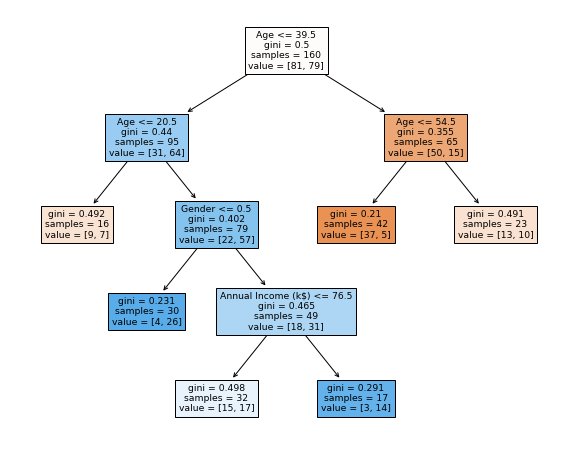

In [ ]:
from sklearn import tree
fig = plt.figure(figsize=(10,8))
_ = tree.plot_tree(clf_final, 
                   feature_names = X_train.columns.to_list(),
                   filled=True)

In our decision tree Age appeared to be the most important feature as it is used in the root node and following two nodes in the 2nd layer. We end up with six leaf nodes:  
1. Age <= 20.5
2. Age > 20.5

# 4 Extreme Gradient Boosting (XGBoost)
First we are going to start by separating out the predictor variables (x) from the target variable (y).


In [ ]:
X = df.iloc[:, :-2]
X

,Gender,Age,Annual Income (k$)
CustomerID,,,
1,Male,19,15
2,Male,21,15
3,Female,20,16
4,Female,23,16
5,Female,31,17


In [ ]:
y = df.iloc[: , -2:-1]
y.head(5)

,Spending Score (1-100)
CustomerID,
1,39
2,81
3,6
4,77
5,40


In [ ]:
y.value_counts().head(5)

Spending Score (1-100)
42                        8
55                        7
46                        6
73                        6
35                        5
dtype: int64

We initialized an instance of the XGBRegressor class. Then we selected the value of Lambda and Gamma as well as the number of estimators and maximum tree depth.

We leveraged OneHot encoding to turn Categorical variables into Numeric variables by converting the string class values to integer values
:

In [ ]:
xgb_regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)


xgb_model = pipeline_model(xgb_regressor)

We then split the data into training and test sets with a 80/20 split.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 51)


#### **Fitting the XGBoost Model**
Now we are going to fit the XGBoost model.

In [ ]:
xgb_model.fit(X_train, y_train)

[22:47:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc239b26490>),
                                                 ('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc239b26ed0>)])),
                ('model', XGBRegressor())])

Now we will use the test set to predict

In [ ]:
y_pred = xgb_model.predict(X_test)

Finding the accuracy, or the $R^{2}$ regression score, using the test set

---


$R^{2}$ is the coefficient of determination.



In [ ]:
 xgb_model.score(X_test, y_test)
 

0.1967696207455586

XGBoost has an accuracy of 19.68%



In [ ]:
linear_model.score(lm_X_test, lm_y_test)

0.09166444709506338

Linear Regression has an accuracy lower than 10%

As we can tell, due to the lack of important features in the dataset, there is no way for us to achieve an extremly high accuracy like in the 95% range. As illustrated above, the accuracy for XGBoost is merely 19.68%, which is already significantly higher than the Linear Regression Model at 9.17%. The only way we can optimize the model further is by evaluting the the performance via some more traditional metrics like Mean Squared Error (MSE) and Root Mean Squared Error (RMSE). The goal is to get the model with the lowest combination of MAPE, MSE ,and RMSE.

### Performance Metrics a: Mean Squared Error (MSE)

In [ ]:
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_mse

431.45469619753624

In [ ]:
# y_pred_lm = linear_model.predict(lm_X_test)
# mean_squared_error(y_pred_lm, lm_y_test)

### Performance Metrics b: Root Mean Squared Error (RMSE)



In [ ]:
xgb_rmse = mean_squared_error(y_test, y_pred, squared=False)
xgb_rmse

20.771487577868278

## Performance Metrics c: Mean Absolute Percentage Error (MAPE)

In [ ]:
xgb_mape =  mean_absolute_percentage_error(y_test, y_pred)
xgb_mape

0.6716931852372368

In [ ]:
# mean_squared_error(y_pred_lm, lm_y_test, squared=False)

In [ ]:
# the same as .score function 
r2_score(y_test, y_pred)

0.1967696207455586

#**Model Comparison**
Now we will compare our models to see which performed best.

## Linear Regression

In [ ]:
y_pred_lm = linear_model.predict(lm_X_test)
lin_reg_mse = mean_squared_error(y_pred_lm, lm_y_test)
lin_reg_rmse = mean_squared_error(y_pred_lm, lm_y_test, squared=False)
lin_reg_mape = mean_absolute_percentage_error(y_pred_lm, lm_y_test)

<!-- ## Logistic Regression -->

In [ ]:
# saved for Logistic Regression (don't remove)
# y_pred_logm = linear_model.predict(logm_X_test)
# log_reg_mse = mean_squared_error(y_pred_logm, logm_y_test)
# log_reg_rmse = mean_squared_error(y_pred_logm, logm_y_test, squared=False)

In [ ]:
data1 = {'metric':['MSE', 'RMSE', 'MAPE'], 'Linear Regression': [lin_reg_mse, lin_reg_rmse, lin_reg_mape], 'XGBoost Regressor': [xgb_mse, xgb_rmse, xgb_mape]}
mc = pd.DataFrame(data=data1)
mc

,metric,Linear Regression,XGBoost Regressor
0,MSE,588.281250,431.454696
1,RMSE,24.254510,20.771488
2,MAPE,0.413605,0.671693


## The final tuned model has to be done using pyCaret, which requires a specific version of scikit-learn. That means we have to continue the model comparison and conclusion part for the regression problem in a separate notebook (collab notebook) [data622_final_pt2.ipynb](https://colab.research.google.com/drive/1D9WKk9jFngCPnNP42yKDcvHpjnlWIhnL?authuser=1#scrollTo=c8Wf2WI0tTLm).

## For the classification problem, this is a summary of what the performance of each of the models

In [ ]:
data2 = {'metric':['accuracy'], 'Logistic Regression': [0.725], 'Support Vector Machine': [0.7]}
mc2 = pd.DataFrame(data=data2)
mc2

,metric,Logistic Regression,Support Vector Machine
0,accuracy,0.725,0.7


#**Conclusion**

We had 3 different kind of analysis throughout our report: 
1. Customer Profiling 
2. Classification Problem: binary (or dichotomous) target predictions
3. Regression Problem: Numerical predictions of Spending Score 

This is representative of what a real company would go through when analyzing their own customer data.  Each one of these types of analysis required manipulating our original data to fit the modeling technique.  Every analysis provided different actionable insights that can used to help identify customer patterns and increase customer spending rates.

For instance, by **clustering using kMeans**, we were able to see that women tend to dominate high paying customers.  Customers over age 60 have less income and it might be helpful to find their occupation.  It would be interesting to see if this group is mostly retired.  Their spending habits likely differ than other groups.  It would also be helpful for the mall owner to collect data like average purchase cost to help drill down on customers spending habits. For higher cost items, you may want to target women since they make more money and could potentially have more disposable income



We realized that despite the data being numeric, regression did not fit well and because of that it would be difficult to predict the actual spending score accurately. We opted to change the problem into a classifaction one and got much better results from doing so. Although not as precise as regression, our models can still be used to predict a group of spender (above average or below average spender) before being assigned spending score; cutting in half the number of people a marketing agency would try to target